In [4]:
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import random

# the coefficient takes values in [0, 1], where 0 is the worst score, 1 is the best score
# the dice coefficient of two sets represented as vectors a, b ca be computed as (2 *|a b| / (a^2 + b^2))
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps)

2023-11-12 10:19:53.147970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 10:19:55.394538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/g-laris89/anaconda3/envs/napari-env/lib/python3.9/site-packages/cv2/../../lib64:
2023-11-12 10:19:55.394653: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-12 10:19:58.914450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'li

In [69]:
# INPUT
# Write model ESRF_Seg_Hands_on_best_model.h5 path
model_path_ = "/home/g-laris89/DEEP-NAPARI/Exercise-4_My first widget/model/ESRF_Seg_Hands_on_best_model.h5"
input_ = "/home/g-laris89/DEEP-NAPARI/Exercise-2_Notebook_Code/images/03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a.png"

model_New = tf.keras.models.load_model(model_path_,custom_objects={'dice_coefficient': dice_coefficient})

_, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = list(model_New.input.shape)

img_ = imread(input_)

nbr_image = len(img_.shape)
if nbr_image==3:
    img_ = img_[:,:,:IMG_CHANNELS]
    X = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    h_or, w_or, _ = img_.shape
    ORIGIN = np.zeros((1, h_or, w_or, IMG_CHANNELS), dtype=np.uint8)
    ORIGIN[0] = img_
    img = resize(img_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[0] = img
elif nbr_image==4:
    img_ = img_[:,:,:,:IMG_CHANNELS]
    X = np.zeros((img_.shape[0], IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    shape_h, shape_w = [], []
    for i in range(img_.shape[0]):
        print(img_[i,...].shape)
        shape_h.append(img_[i,...].shape[0])
        shape_w.append(img_[i,...].shape[1])
        img = resize(img_[i,...], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[i] = img
        
    ORIGIN = np.zeros((img_.shape[0],np.max(shape_h),np.max(shape_w),IMG_CHANNELS), dtype=np.uint8) 
    for i in range(img_.shape[0]):
        ORIGIN[i,...][:shape_h[i], :shape_w[i],:] = img_[i,...]

preds_test = model_New.predict(X, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_test_opt = (preds_test > 0.5).astype(np.uint8)

if nbr_image==3:
    result_ = np.squeeze(preds_test_opt[0, :, :, 0])
    output_ = np.zeros((1,h_or,w_or), dtype=np.uint8)
    res_ = resize(result_, (h_or, w_or), mode='constant', preserve_range=True)
    output_[0] = res_
elif nbr_image==4:
    img_ = img_[:,:,:,:IMG_CHANNELS]
    result_ = np.squeeze(preds_test_opt[:, :, :, 0])
    output_ = np.zeros((img_.shape[0],np.max(shape_h),np.max(shape_w)), dtype=np.uint8)
    for i in range(img_.shape[0]):
        res_ = resize(result_[i], (shape_h[i], shape_w[i]), mode='constant', preserve_range=True)
        output_[i,...][:shape_h[i], :shape_w[i]] = res_

1/1 [==============================] - 0s 290ms/step


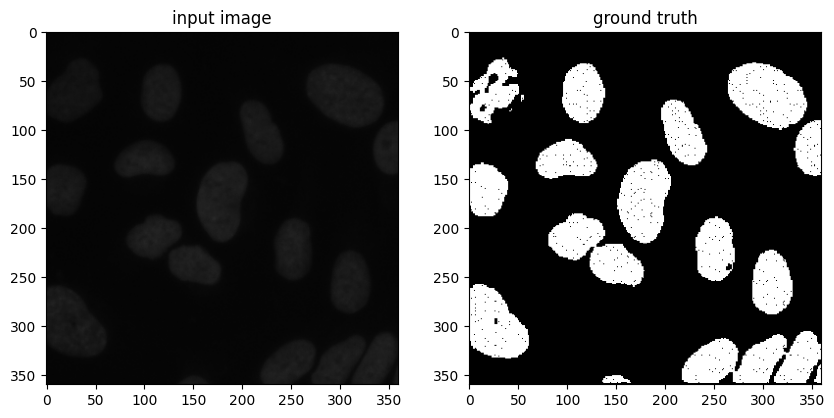

In [70]:
#OPTIONAL : DISPLAY
if nbr_image==3:
    ix=0
else:
    ix = random.randint(0,img_.shape[0])
fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(ORIGIN[ix], cv2.COLOR_BGR2RGB))
plt.title("input image")
plt.subplot(122)
plt.imshow(output_[ix,...], cmap='gray')
plt.title("ground truth")
# show the plot
plt.show()